In [1]:
import pathlib
from joblib import load
import json
import sys
import os

import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import numpy as np

sys.path.append("../")
from src.classification.classification import show_params, prepare_data_for_training
from src.data_preparation.preprocessing import run_preprocessing
from src.data_preparation.features import extract_features, make_final_df

In [2]:
EXPERIMENTS_PATH = pathlib.Path("../experiments")
date = "01_20_11_53_06_svm"
experiment_path = EXPERIMENTS_PATH / date

In [3]:
def load_model(experiment_path):
    model = load(experiment_path / "model.joblib")
    return model

def load_clustering_model(experiment_path):
    clustering_model = load(experiment_path / "clustering_model.joblib")
    return clustering_model

def load_final_df(experiment_path):
    final_df = pd.read_csv(experiment_path / "final_df.csv")
    return final_df

def load_params(experiment_path):
    with open(experiment_path / "params.json") as file:
        params = json.load(file)
    return params

In [4]:
model = load_model(experiment_path)
clustering_model = load_clustering_model(experiment_path)
final_df = load_final_df(experiment_path)
params = load_params(experiment_path)

In [5]:
show_params(params)



#######################
# Run with parameters #
#######################

images_path = data/interim/images
labels_path = data/interim/labels.csv
models_path = models
final_data_path = data/cache
segmentation = MSER
descriptors_proportion = 1.0
clustering_method = kmeans
n_clusters = 800
do_clustering = False
classification_model = svm
n_data = 10000
use_df = True
date = 01_20_11_53_06


In [6]:
final_df

,0,1,2,3,4,5,6,7,8,9,...,792,793,794,795,796,797,798,799,path,label
0,0,0,0,0,0,3,0,1,0,1,...,0,1,1,0,0,0,2,0,dog.8011.jpg,dog
1,0,2,0,1,0,0,1,1,0,0,...,0,1,0,1,1,1,0,0,cat.5077.jpg,cat
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,dog.7322.jpg,dog
3,0,0,0,0,0,2,0,8,0,0,...,0,2,0,0,2,1,4,0,cat.2718.jpg,cat
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,cat.10151.jpg,cat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,2,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,1,0,cat.4522.jpg,cat
9990,2,2,1,2,0,1,3,3,0,2,...,0,1,2,2,1,0,0,0,dog.6677.jpg,dog
9991,7,4,0,1,1,4,1,8,6,3,...,3,1,6,1,3,2,0,4,dog.9544.jpg,dog
9992,2,5,0,2,1,1,5,0,3,5,...,4,2,1,0,0,1,0,0,cat.11404.jpg,cat


# Metrics on Kaggle dataset

In [7]:
X_scaled, y, scaler = prepare_data_for_training(
    final_df.drop("path", axis=1)
)
X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=1 / 3, random_state=42
    )

In [8]:
y_pred = model.predict(X_test)

In [9]:
def show_matrix(y_pred, y):
    confusion_matrix_ = confusion_matrix(y, y_pred, labels=["cat", "dog"])
    ConfusionMatrixDisplay(confusion_matrix_, display_labels=["cat", "dog"]).plot()
    return confusion_matrix_

In [10]:
def show_metrics(confusion_matrix_):
    accuracy = np.trace(confusion_matrix_) / np.sum(confusion_matrix_)
    cat_precision = confusion_matrix_[0, 0] / (confusion_matrix_[0, 0] + confusion_matrix_[0, 1])
    dog_precision = confusion_matrix_[1, 1] / (confusion_matrix_[1, 1] + confusion_matrix_[1, 0])

    cat_recall = confusion_matrix_[0, 0] / (confusion_matrix_[0, 0] + confusion_matrix_[1, 0])
    dog_recall = confusion_matrix_[1, 1] / (confusion_matrix_[1, 1] + confusion_matrix_[0, 1])

    print(
        f"""\n
        Accuracy: {accuracy*100:.2f} % 

        Cat precision: {cat_precision*100:.2f} %
        Cat recall: {cat_recall*100:.2f} %

        Dog precision: {dog_precision*100:.2f} %
        Dog recall: {dog_recall*100:.2f} %
        """
    )

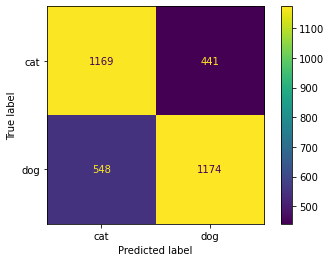

In [11]:
confusion_matrix_ = show_matrix(y_pred, y_test)

In [12]:
show_metrics(confusion_matrix_)



        Accuracy: 70.32 % 

        Cat precision: 72.61 %
        Cat recall: 68.08 %

        Dog precision: 68.18 %
        Dog recall: 72.69 %
        


## Metrics on PASCAL dataset

In [13]:
final_df

,0,1,2,3,4,5,6,7,8,9,...,792,793,794,795,796,797,798,799,path,label
0,0,0,0,0,0,3,0,1,0,1,...,0,1,1,0,0,0,2,0,dog.8011.jpg,dog
1,0,2,0,1,0,0,1,1,0,0,...,0,1,0,1,1,1,0,0,cat.5077.jpg,cat
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,dog.7322.jpg,dog
3,0,0,0,0,0,2,0,8,0,0,...,0,2,0,0,2,1,4,0,cat.2718.jpg,cat
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,cat.10151.jpg,cat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,2,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,1,0,cat.4522.jpg,cat
9990,2,2,1,2,0,1,3,3,0,2,...,0,1,2,2,1,0,0,0,dog.6677.jpg,dog
9991,7,4,0,1,1,4,1,8,6,3,...,3,1,6,1,3,2,0,4,dog.9544.jpg,dog
9992,2,5,0,2,1,1,5,0,3,5,...,4,2,1,0,0,1,0,0,cat.11404.jpg,cat


In [14]:
pascal_path = pathlib.Path("../data/pascal")
images_path = pascal_path / "images"
labels_path = pascal_path / "labels.csv"

In [15]:
descriptors_dict = run_preprocessing(images_path, 1, "MSER", len(os.listdir(images_path)))

100%|██████████| 742/742 [00:12<00:00, 58.42it/s]


In [17]:
features = extract_features(descriptors_dict, clustering_model)

100%|██████████| 741/741 [00:01<00:00, 459.79it/s]


In [18]:
labels = pd.read_csv(labels_path)
pascal_df = make_final_df(features, labels)

In [19]:
pascal_df

,0,1,2,3,4,5,6,7,8,9,...,792,793,794,795,796,797,798,799,path,label
0,1,0,0,4,1,1,3,0,0,2,...,0,0,0,1,1,0,3,0,003301.jpg,dog
1,1,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,008254.jpg,cat
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,005980.jpg,cat
3,0,1,0,2,1,4,1,3,0,1,...,1,5,5,0,0,0,0,1,004446.jpg,cat
4,0,0,0,1,1,0,0,3,0,0,...,0,0,0,1,0,0,0,1,009823.jpg,dog
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,0,1,0,0,0,1,2,1,0,0,...,0,0,0,1,0,0,0,0,006512.jpg,cat
737,0,2,0,0,0,0,1,2,0,0,...,0,0,1,0,0,0,0,0,002760.jpg,cat
738,0,1,2,0,1,1,3,1,0,0,...,0,0,4,0,0,0,0,0,006260.jpg,cat
739,1,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,1,0,005769.jpg,cat


In [21]:
X_pascal, y_pascal, scaler_pascal = prepare_data_for_training(
    pascal_df.drop("path", axis=1)
)

In [22]:
y_pascal_pred = model.predict(X_pascal)

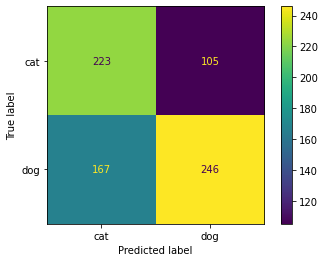

In [23]:
confusion_matrix_pascal = show_matrix(y_pascal_pred, y_pascal)

In [24]:
show_metrics(confusion_matrix_pascal)



        Accuracy: 63.29 % 

        Cat precision: 67.99 %
        Cat recall: 57.18 %

        Dog precision: 59.56 %
        Dog recall: 70.09 %
        
